In [1]:
%load_ext autoreload
%autoreload 2

# core

> Core utilities

In [2]:
#| default_exp core

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import cv2
import nd2
import torch
import fastcore.all as fc

In [5]:
from minai import *

## Image processing

In [6]:
path = fc.Path.home()/'data/pili/training_data'
path.ls()

(#18) [Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.nd2'),Path('/home/kappa/data/pili/training_data/1hr01002.csv'),Path('/home/kappa/data/pili/training_data/0N01002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.nd2'),Path('/home/kappa/data/pili/training_data/0.1%.004.nd2'),Path('/home/kappa/data/pili/training_data/4hrs incu004.csv'),Path('/home/kappa/data/pili/training_data/1hr01002.nd2'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.nd2'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv'),Path('/home/kappa/data/pili/training_data/0N01002.csv'),Path('/home/kappa/data/pili/training_data/4hrs incu004.nd2'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.csv'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.nd2'),Path('/home/kappa/data/pili/training_data/7.1- 003.csv'),Path('/hom

In [7]:
#| export
def get_im(x): return nd2.imread(x)[0]

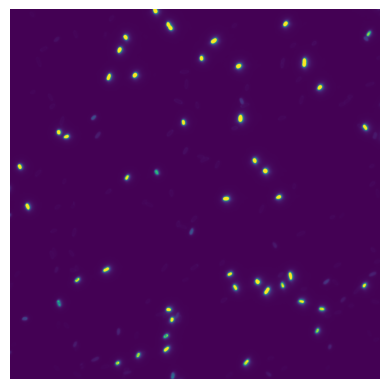

In [8]:
im = get_im(path/'0N01002.nd2')
show_image(im);

In [9]:
df = pd.read_csv(path/'0N01002.csv')

TODO: make `class_index` 0-based.

In [10]:
#| export
def calc_corners(csv, max_pos = 8.458666666666666e-05):
    df = pd.read_csv(csv)
    results = []
    for _, row in df.iterrows():
        length = row['Length']
        width = row['Width']
        angle = row['Angle']
        pos_x = row['Position X']
        pos_y = row['Position Y']

        x1 = pos_x + length/2 * np.cos(angle) - width/2 * np.sin(angle)
        y1 = pos_y + length/2 * np.sin(angle) + width/2 * np.cos(angle)
        x2 = pos_x - length/2 * np.cos(angle) - width/2 * np.sin(angle)
        y2 = pos_y - length/2 * np.sin(angle) + width/2 * np.cos(angle)
        x3 = pos_x - length/2 * np.cos(angle) + width/2 * np.sin(angle)
        y3 = pos_y - length/2 * np.sin(angle) - width/2 * np.cos(angle)
        x4 = pos_x + length/2 * np.cos(angle) + width/2 * np.sin(angle)
        y4 = pos_y + length/2 * np.sin(angle) - width/2 * np.cos(angle)
        results.append([row['Type'], x1, y1, x2, y2, x3, y3, x4, y4])

    df = pd.DataFrame(results, columns=['class_index', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
    df = pd.concat([df.iloc[:, 0], df.iloc[:, 1:] / max_pos], axis=1)
    return torch.tensor(df.to_numpy())

In [11]:
y = calc_corners(path/'0N01002.csv')
y[:5]

tensor([[1.0000, 0.1295, 0.9836, 0.1110, 0.9670, 0.1205, 0.9565, 0.1390, 0.9731],
        [1.0000, 0.1901, 0.9989, 0.1651, 0.9883, 0.1706, 0.9752, 0.1957, 0.9859],
        [1.0000, 0.1547, 0.8677, 0.1389, 0.8501, 0.1494, 0.8406, 0.1652, 0.8582],
        [1.0000, 0.3313, 0.8914, 0.3377, 0.8674, 0.3514, 0.8710, 0.3450, 0.8950],
        [6.0000, 0.3144, 0.9890, 0.3142, 0.9996, 0.3000, 0.9994, 0.3002, 0.9887]],
       dtype=torch.float64)

In [12]:
#| export
@fc.delegates(plt.Axes.imshow)
def imshow_with_boxes(im, boxes, figsize=(8,8), **kwargs):
    import matplotlib.patches as patches
    colors = {
        1: 'red',    # GREEN YELLOW
        2: 'blue',   # TURQUOISE
        3: 'green',  # THISTLE 
        4: 'yellow', # COrAL
        5: 'purple', # WHITE
        6: 'orange'  # MAGENTA
    }
    class_names = {
        1: 'Type 1 - Both poles free',
        2: 'Type 2 - One pole occluded',
        3: 'Type 3 - Both poles occluded',
        4: 'Type 4 - Super bright cell',
        5: 'Type 5 - Very dim cell',
        6: 'Type 6 - Partial cell'
    }

    height, width = im.shape[:2]
    fig, ax = plt.subplots(figsize=figsize)
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    plt.axis('off')

    unique_classes = boxes[:,0].unique().int().tolist()
    legend_elements = [patches.Patch(facecolor='none',
                                   edgecolor=colors[class_idx],
                                   label=class_names[class_idx])
                      for class_idx in unique_classes]

    for box in boxes:
        class_idx = box[0].item()
        corners = [[box[1].item() * width, box[2].item() * height],
                  [box[3].item() * width, box[4].item() * height],
                  [box[5].item() * width, box[6].item() * height],
                  [box[7].item() * width, box[8].item() * height]]

        color = colors.get(box[0].item(), 'white')
        polygon = patches.Polygon(corners, fill=False,
                                edgecolor=color,
                                linewidth=2)
        ax.add_patch(polygon)

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

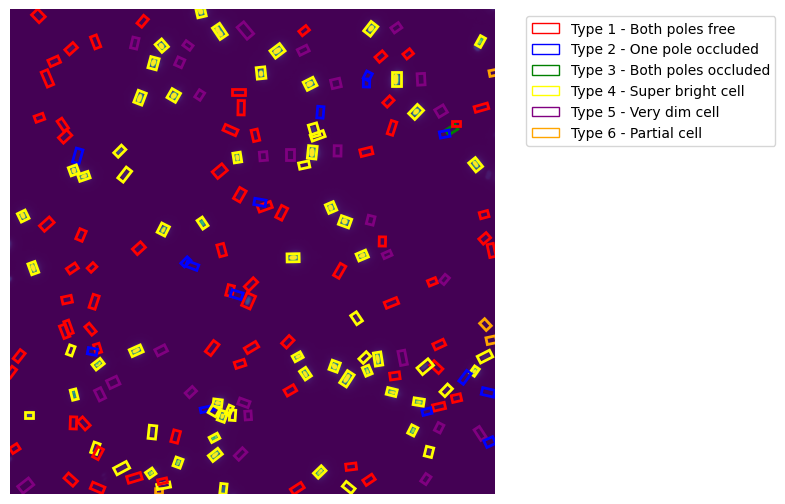

In [13]:
imshow_with_boxes(im, y)

## CLAHE

Tackling low signal problem: Let's take a look at an image with labels.

How CLAHE (Contrast Limited Adaptive Histogram Equalization) works:

1. Basic Principle:
- Unlike regular histogram equalization which works on the entire image at once, CLAHE works on small regions (tiles) of the image
- This local approach helps maintain local details and contrast

2. Step-by-Step Process:
   - The image is divided into small tiles (defined by tile_grid_size)
   - For each tile:
     - A local histogram is computed
     - The histogram is clipped at a predetermined value (clip_limit) to prevent noise amplification
     - Histogram equalization is applied to that tile
   - Bilinear interpolation is used to eliminate artificial boundaries between tiles

3. Key Advantages:
   - Better handling of local contrast
   - Prevents over-amplification of noise (through clipping)
   - Preserves edges and local details
   - Works well with varying brightness levels in different image regions

4. Parameters Impact:
   - clip_limit: Higher values allow more contrast enhancement but may increase noise
   - tile_grid_size: Smaller tiles give more local enhancement but might make the image look "patchy"

In [14]:
im.shape

(1952, 1952)

In [15]:
im.dtype

dtype('uint16')

In [16]:
#| export
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(image)
    return enhanced

In [17]:
#| export
def compare_ims(img1, img2):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title('img1')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.title('img2')
    plt.axis('off')

    plt.show()

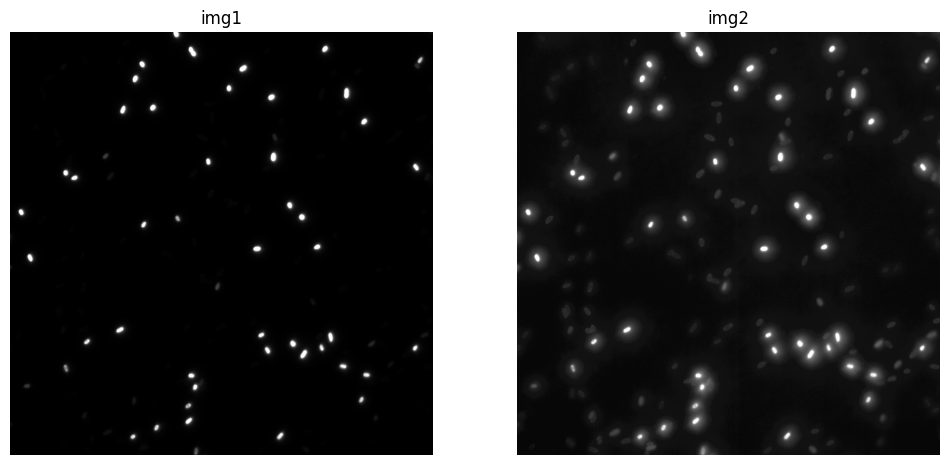

In [18]:
enh = apply_clahe(im, clip_limit=10.1, tile_grid_size=(8,8))
compare_ims(im, enh)

In [19]:
#| hide
import nbdev; nbdev.nbdev_export()